In [1]:
import sys
import os
import torch
from src.GAWNN import GeneratorGAWNN
import numpy as np
from torch.autograd import Variable
from collections import defaultdict
torch.cuda.set_device(4)

device = torch.device("cuda:4")

In [2]:
from matplotlib import pyplot as plt
from src.GAWNN import DiscriminatorGAWNN
from loader import get_train_loader

In [3]:
train_loader = get_train_loader("/home/aafilatov/data/deepfashion/index.p")

In [4]:
batch_size = 16
train_loader = get_train_loader("index.p", batch_size=batch_size, resize_size=128)

In [5]:
hidden_size = 16
z_size = 16
generator = GeneratorGAWNN(hidden_size=hidden_size, z_size=z_size, appearance_size=128, position_size=18).to(device)

In [6]:
discriminator = DiscriminatorGAWNN(image_size=128, appearance_size=128, position_size=18, hidden_size=16).to(device)

In [7]:
def g_loss(disc_output_gen):
    res = -torch.mean(torch.log(torch.clamp(disc_output_gen, 1e-4, 0.9999)))
    return res

def d_loss(disc_output_gen, disc_output_real):
    res = -(torch.mean(torch.log(torch.clamp(disc_output_real, 1e-4, 0.9999))) + torch.mean(torch.log1p(-torch.clamp(disc_output_gen, 1e-4, 0.9999))))
    return res

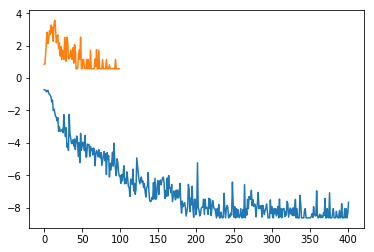

0
[-6.785571, 1.3154644]



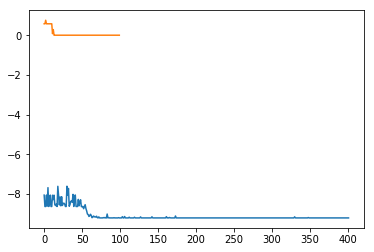

1
[-9.0897455, 0.06882607]



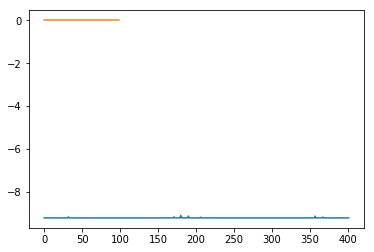

2
[-9.208981, 0.00010002158]



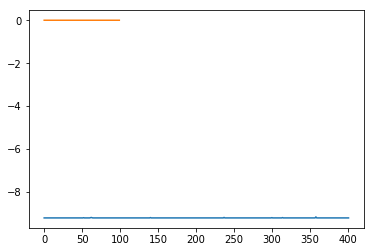

3
[-9.209757, 0.000100175756]



KeyboardInterrupt: 

In [8]:
from torch import optim

lr = 0.0002

g_optimizer = optim.Adam(generator.parameters(),     lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

num_epochs = 100

learning_history = []

for epoch in range(num_epochs):
    i = 0
    
    epoch_generator_history = []
    epoch_discriminator_history = []
    
    for x, y in train_loader:
        x = x * 2 - 1
        z = torch.ones(len(x), z_size).normal_().cuda()
        z = z / torch.norm(z, dim=1)[:, None]
        
        appearance = x[:, 0].cuda()
        position = (y[:, 1].cuda().type(torch.cuda.LongTensor) + 256) / 32
        generated = generator(z, appearance, position)
        
        
        if i < 4:
            
            true_pictures = x[:, 1].cuda()
            true_response = discriminator(true_pictures, appearance, position)
            loss = -(torch.mean(torch.log(torch.clamp(true_response, 1e-4, 0.9999))))
            d_optimizer.zero_grad()
            loss.backward()
            #print(loss.data)
            d_optimizer.step()
                     
            generated_response = discriminator(generated, appearance, position)
            loss = torch.mean(torch.log1p(-torch.clamp(generated_response, 1e-4, 0.9999)))
            d_optimizer.zero_grad()
            loss.backward()
            #print(loss.data)
            d_optimizer.step()
            
            i += 1
            epoch_discriminator_history.append(loss.data.cpu().numpy())

        else:
            generated_response = discriminator(generated, appearance, position)
            loss = g_loss(generated_response)
            g_optimizer.zero_grad()
            loss.backward()
            # print(loss.data)
            g_optimizer.step()
            epoch_generator_history.append(loss.data.cpu().numpy())
            
            i = 0
            
    plt.plot(epoch_discriminator_history, label='disc')
    plt.plot(epoch_generator_history, label='gen')
    plt.show()
    learning_history.append([np.mean(epoch_discriminator_history), \
                            np.mean(epoch_generator_history)])
    print(epoch)
    print(learning_history[-1])
    print()

